# 2. MULTIVARIATE K-NEAREST NEIGHBORS
---

## 1. Introducing the Data

In [1]:
import pandas as pd
import numpy as np

file = 'data/dc_airbnb.csv'
cols = ['accommodates', 'bedrooms', 'bathrooms', 'beds', 'price', 
        'minimum_nights', 'maximum_nights', 'number_of_reviews']
dc = pd.read_csv(file)
dc = dc[cols]
dc.head()

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
0,4,1.0,1.0,2.0,$160.00,1,1125,0
1,6,3.0,3.0,3.0,$350.00,2,30,65
2,1,1.0,2.0,1.0,$50.00,2,1125,1
3,2,1.0,1.0,1.0,$95.00,1,1125,0
4,4,1.0,1.0,1.0,$50.00,7,1125,0


In [2]:
dc.shape

(3723, 8)

## 2. Cleaning the Price Column

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class PriceCleaner(BaseEstimator, TransformerMixin):    
    def __init__(self):
        self  
    def fit(self, df, y = None):               
        return self
    def transform(self, df):               
        df = df.copy()
        no_comma = df['price'].str.replace(',', '')
        no_dollar = no_comma.str.replace('$', '')
        df['price'] = no_dollar.astype('float')
        return df
    
pricer = PriceCleaner()
dc_priced = pricer.transform(dc)
dc_priced.head()

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
0,4,1.0,1.0,2.0,160.0,1,1125,0
1,6,3.0,3.0,3.0,350.0,2,30,65
2,1,1.0,2.0,1.0,50.0,2,1125,1
3,2,1.0,1.0,1.0,95.0,1,1125,0
4,4,1.0,1.0,1.0,50.0,7,1125,0


## 3. Dealing with Outliers

In [4]:
dc_priced.max() - dc_priced.min()

accommodates         1.500000e+01
bedrooms             1.000000e+01
bathrooms            8.000000e+00
beds                 1.500000e+01
price                2.812000e+03
minimum_nights       1.790000e+02
maximum_nights       2.147484e+09
number_of_reviews    3.620000e+02
dtype: float64

The `maximum_nights` column is the only problem we have when it comes to outliers; a 2-billion difference? Once can assume that the maximum nights values were entered arbitrarily and, therefore, are not that meaningful. This means I can limit these extreme values to a certain arbitrary value, closer to the mean of the distribution, without losing meaningful information in the data. A typical strategy I can use involves setting outliers to a specified percentile.
- For example, with 90% winsorization, I would set:
    - all data below the 5th percentile to the value at the 5th percentile and 
    - all data above the 95th percentile to the value at the 95th percentile.
- However, I am not touching the lower values, so only the `high outliers will be winsorized to 99.9th percentile`.

In [5]:
dc_priced['maximum_nights'].quantile(0.999)

2000.0

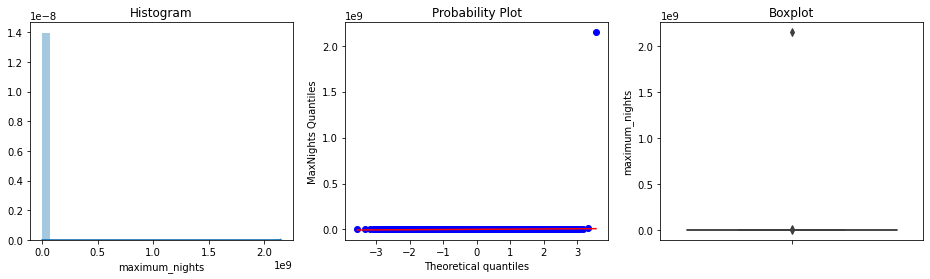

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def diagnostic_plots(df, variable):   
    plt.figure(figsize=(16, 4))
   
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')
   
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('MaxNights Quantiles')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()
    
# let's plot RM
diagnostic_plots(dc_priced, 'maximum_nights')

In [7]:
# 99th winsorization function 
def winsoriser(df, variable):
    ul = df[variable].quantile(0.999)
    return np.where(df[variable] > ul, 
                    ul, df[variable])
dc_priced['maximum_nights'] = winsoriser(dc_priced, 'maximum_nights')
dc_priced.max() - dc_priced.min()

accommodates           15.0
bedrooms               10.0
bathrooms               8.0
beds                   15.0
price                2812.0
minimum_nights        179.0
maximum_nights       1999.0
number_of_reviews     362.0
dtype: float64

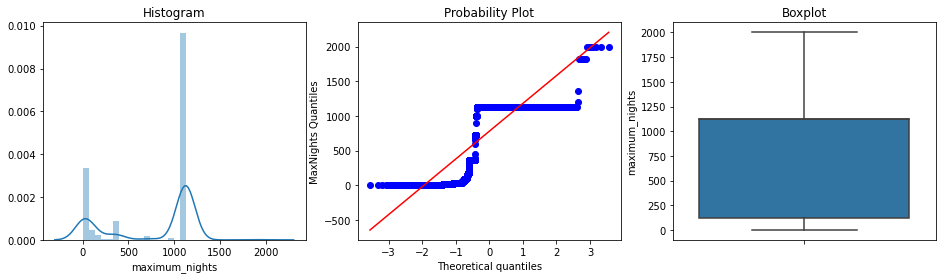

In [8]:
diagnostic_plots(dc_priced, 'maximum_nights')

## 4. Imputing Missing Data

In [9]:
dc_priced.isnull().mean().sort_values(ascending=True)

accommodates         0.000000
price                0.000000
minimum_nights       0.000000
maximum_nights       0.000000
number_of_reviews    0.000000
beds                 0.002955
bedrooms             0.005641
bathrooms            0.007252
dtype: float64

In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputer.fit(dc_priced)
dc_imputed = imputer.transform(dc_priced)

dc_imputed = pd.DataFrame(dc_imputed)
dc_imputed.columns = cols
dc_imputed.isnull().mean()

accommodates         0.0
bedrooms             0.0
bathrooms            0.0
beds                 0.0
price                0.0
minimum_nights       0.0
maximum_nights       0.0
number_of_reviews    0.0
dtype: float64

In [11]:
dc_imputed.shape

(3723, 8)

## 5. Train-Test Splitting

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dc_imputed, test_size=0.2, random_state=42)
train.shape, test.shape

train.to_csv('data/dc_train')
test.to_csv('data/dc_test')

X_train = train.drop('price', axis=1)
y_train = train['price']

X_test = test.drop('price', axis=1)
y_test = test['price']

X_cols = X_train.columns

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2978, 7), (2978,), (745, 7), (745,))

## 6. Data Standardization

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled)
X_train.columns = X_cols
X_train.head()

,accommodates,bedrooms,bathrooms,beds,minimum_nights,maximum_nights,number_of_reviews
0,0.392503,-0.249075,-0.436195,0.313088,-0.073419,0.697780,-0.018695
1,0.392503,-0.249075,-0.436195,-0.552628,-0.325020,0.697780,0.150325
2,-0.593473,-0.249075,-0.436195,-0.552628,-0.325020,0.697780,-0.221520
3,0.885491,0.943443,1.274127,1.178805,0.178182,-0.106969,0.116521
4,1.378479,0.943443,-0.436195,0.313088,-0.073419,-1.522921,-0.018695


In [14]:
scaler.mean_

array([  3.20382807,   1.20886501,   1.25503694,   1.63834788,
         2.29180658, 782.50436535,  15.55305574])

In [15]:
scaler.scale_

array([  2.02844748,   0.83856147,   0.58468518,   1.15511254,
         3.97454206, 490.83603328,  29.5822953 ])

In [16]:
scaler.n_samples_seen_

2978

In [17]:
X_train.describe()

,accommodates,bedrooms,bathrooms,beds,minimum_nights,maximum_nights,number_of_reviews
count,2.978000e+03,2.978000e+03,2.978000e+03,2.978000e+03,2.978000e+03,2.978000e+03,2.978000e+03
mean,9.081609e-17,-4.332032e-17,1.521431e-16,9.357488e-17,2.654768e-16,-5.562299e-17,-4.615366e-17
std,1.000168e+00,1.000168e+00,1.000168e+00,1.000168e+00,1.000168e+00,1.000168e+00,1.000168e+00
min,-1.086461e+00,-1.441594e+00,-2.146517e+00,-5.526283e-01,-3.250202e-01,-1.592190e+00,-5.257555e-01
25%,-5.934726e-01,-2.490754e-01,-4.361953e-01,-5.526283e-01,-3.250202e-01,-1.349747e+00,-4.919515e-01
50%,-5.934726e-01,-2.490754e-01,-4.361953e-01,-5.526283e-01,-7.341892e-02,6.977801e-01,-3.905395e-01
75%,3.925031e-01,-2.490754e-01,-4.361953e-01,3.130882e-01,1.781824e-01,6.977801e-01,4.891251e-02
max,6.308358e+00,1.048359e+01,1.153606e+01,1.243312e+01,4.471161e+01,2.480453e+00,1.090000e+01


In [18]:
X_test = pd.DataFrame(X_test_scaled)
X_test.columns = X_cols
X_test.head()

,accommodates,bedrooms,bathrooms,beds,minimum_nights,maximum_nights,number_of_reviews
0,0.392503,-0.249075,-0.436195,-0.552628,-0.325020,0.697780,-0.153912
1,-0.593473,-0.249075,-0.436195,-0.552628,-0.073419,-1.565705,-0.086304
2,-0.593473,-0.249075,-0.436195,-0.552628,0.178182,0.697780,-0.525756
3,0.392503,-1.441594,-0.436195,0.313088,-0.325020,0.697780,0.555973
4,-0.593473,-0.249075,-0.436195,-0.552628,-0.325020,0.697780,0.454561


In [19]:
X_test.shape

(745, 7)

## 7. Training KNN on All Features

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor(algorithm='brute')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print('MSE_train:', mse)
print('RMSE_train:', rmse)

MSE_train: 10515.422149093352
RMSE_train: 102.54473242977112


In [21]:
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MSE_test:', mse)
print('RMSE_test:', rmse)

MSE_test: 11454.521932885906
RMSE_test: 107.02580031415745
